In [1]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import sqlite3
from datetime import datetime
from sklearn.model_selection import GridSearchCV
from datetime import timedelta
import joblib
from keras import backend as K
import pickle

In [2]:
db_file = 'Daten/sensor_daten.sqlite'
conn = sqlite3.connect(db_file)

query = "SELECT * FROM WeatherData"

df_start = pd.read_sql_query(query, conn)

conn.close()
df_start

,createdAt,Temperatur,rel_Luftfeuchte,Luftdruck,Bodenfeuchte,Bodentemperatur,Licht,UV_Index,PM25,PM10,station
0,2022-09-28T00:00:40.694Z,7.96,99.99,998.76,26.00,17.68,0.0,0.0,6.6,1.4,WetterBrg
1,2022-09-28T00:01:40.707Z,7.95,99.99,998.82,26.10,10.26,0.0,0.0,3.1,1.3,WetterBrg
2,2022-09-28T00:02:40.751Z,7.95,99.99,998.82,25.78,10.59,0.0,0.0,3.4,1.3,WetterBrg
3,2022-09-28T00:03:40.645Z,7.95,99.99,998.81,26.16,11.23,0.0,0.0,4.9,1.6,WetterBrg
4,2022-09-28T00:04:40.589Z,7.95,99.99,998.79,25.83,4.79,0.0,0.0,2.2,1.3,WetterBrg
...,...,...,...,...,...,...,...,...,...,...,...
2697978,2024-06-21T23:55:11.185Z,16.68,99.99,979.72,11.23,17.03,0.0,0.0,1.2,5.6,PoS
2697979,2024-06-21T23:56:11.159Z,16.70,99.99,979.70,11.28,19.93,0.0,0.0,0.8,1.5,PoS
2697980,2024-06-21T23:57:11.199Z,16.67,99.99,979.67,11.12,15.42,0.0,0.0,1.0,4.7,PoS
2697981,2024-06-21T23:58:11.142Z,16.67,99.99,979.69,11.23,17.68,0.0,0.0,0.9,1.7,PoS


In [3]:
df_start.station.value_counts()
df_start_w = df_start[df_start['station'] == 'Wald der Zukunft - Stadtbergen']
df_start_new= df_start_w.drop(columns=['station', 'UV_Index'])

In [4]:
thresholds = {
    'Temperatur': (-50, 60), # Grenzwerte gewählt, da es  Messungen bis 950°C gab
    'Luftdruck': (950, 1060), # ungefähr die minimale und maximale jemals in DE gemessenen Werte
    'Bodenfeuchte': (0, 150), # Bodenfeuchte in %, bei starkem Regen können die Werte kurzfristig über 100% steigen
    'Bodentemperatur': (-50, 60), # es gab zum Teil Messungen von 360 Tsd.°C
}

filtered_df = df_start_new.apply(lambda col: col.where((col >= thresholds[col.name][0]) & (col <= thresholds[col.name][1]), np.nan) 
              if col.name in thresholds else col)

In [5]:
df_start_new['createdAt'] = pd.to_datetime(df_start_new['createdAt'], format=('%Y-%m-%dT%H:%M:%S.%fZ')).dt.floor('S')

In [6]:
df_start_new['createdAt'] = pd.to_datetime(df_start_new['createdAt'])
df_start_new['createdAt'] = df_start_new['createdAt'].dt.floor('H')
df_hourly = df_start_new.groupby('createdAt').mean().reset_index()
df_hourly = df_hourly.round(3)
df_hourly

,createdAt,Temperatur,rel_Luftfeuchte,Luftdruck,Bodenfeuchte,Bodentemperatur,Licht,PM25,PM10
0,2022-09-28 00:00:00,7.711,99.990,997.006,3.204,10.589,0.000,0.555,1.358
1,2022-09-28 01:00:00,7.761,99.990,995.855,3.181,10.583,0.000,0.593,1.854
2,2022-09-28 02:00:00,7.656,99.990,994.592,3.194,10.902,0.000,0.625,2.109
3,2022-09-28 03:00:00,8.101,99.931,993.930,3.223,11.101,0.000,0.596,1.932
4,2022-09-28 04:00:00,7.967,99.975,993.180,3.228,11.315,0.000,0.530,1.421
...,...,...,...,...,...,...,...,...,...
8267,2024-06-15 02:00:00,13.764,97.415,1008.750,24.348,12.566,0.000,2.487,6.401
8268,2024-06-15 03:00:00,13.618,98.400,1008.293,24.228,12.575,2.808,2.385,6.301
8269,2024-06-15 04:00:00,14.093,97.409,1009.938,24.219,12.560,9.169,2.136,5.708
8270,2024-06-15 05:00:00,14.155,93.245,1012.120,24.250,12.532,14.376,0.810,2.078


In [7]:
train_dates = pd.to_datetime(df_hourly['createdAt'])
train_dates

0      2022-09-28 00:00:00
1      2022-09-28 01:00:00
2      2022-09-28 02:00:00
3      2022-09-28 03:00:00
4      2022-09-28 04:00:00
               ...        
8267   2024-06-15 02:00:00
8268   2024-06-15 03:00:00
8269   2024-06-15 04:00:00
8270   2024-06-15 05:00:00
8271   2024-06-15 06:00:00
Name: createdAt, Length: 8272, dtype: datetime64[ns]

In [8]:
cols = list(df_hourly)[1:8]

print(cols) 

df_for_training = df_hourly[cols].astype(float)

swap_index = 0
# get a list of the columns
col_list = list(df_for_training)
# use this handy way to swap the elements
col_list[0], col_list[swap_index] = col_list[swap_index], col_list[0]
# assign back, the order will now be swapped
df_for_training.columns = col_list
df_for_training

['Temperatur', 'rel_Luftfeuchte', 'Luftdruck', 'Bodenfeuchte', 'Bodentemperatur', 'Licht', 'PM25']


,Temperatur,rel_Luftfeuchte,Luftdruck,Bodenfeuchte,Bodentemperatur,Licht,PM25
0,7.711,99.990,997.006,3.204,10.589,0.000,0.555
1,7.761,99.990,995.855,3.181,10.583,0.000,0.593
2,7.656,99.990,994.592,3.194,10.902,0.000,0.625
3,8.101,99.931,993.930,3.223,11.101,0.000,0.596
4,7.967,99.975,993.180,3.228,11.315,0.000,0.530
...,...,...,...,...,...,...,...
8267,13.764,97.415,1008.750,24.348,12.566,0.000,2.487
8268,13.618,98.400,1008.293,24.228,12.575,2.808,2.385
8269,14.093,97.409,1009.938,24.219,12.560,9.169,2.136
8270,14.155,93.245,1012.120,24.250,12.532,14.376,0.810


In [9]:
# class StandardScaler:
#     scales: dict

#     def __init__(self, scales):
#         self.scales = scales
    
#     def scale(self, df):
#         for column in df:
#             if column not in self.scales.keys():
#                 continue
#             df[column] = (df[column] - self.scales[column]["mean"]) / self.scales[column]["std"]
#         return df
    
#     def unscale(self, df):
#         for column in df:
#             if column not in self.scales.keys():
#                 continue
#             df[column] = df[column] * self.scales[column]["std"] + self.scales[column]["mean"]
#         return df

#     @staticmethod
#     def fit(df, *skip: str) -> dict:
#         scales: dict = dict()
#         for column in df:
#             if column in skip:
#                 continue

#             mean = df[column].mean()
#             std = df[column].std()
#             scales[column] = {"std": std, "mean": mean}
#         return scales

In [10]:
scaler = MinMaxScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)
df_for_training_scaled

array([[5.38187690e-02, 1.00000000e+00, 9.61956165e-01, ...,
        1.01973333e-02, 0.00000000e+00, 6.94803330e-03],
       [5.39520036e-02, 1.00000000e+00, 9.60845629e-01, ...,
        1.01920000e-02, 0.00000000e+00, 8.03904680e-03],
       [5.36722110e-02, 1.00000000e+00, 9.59627030e-01, ...,
        1.04755556e-02, 0.00000000e+00, 8.95779500e-03],
       ...,
       [7.08248285e-02, 9.65605011e-01, 9.74433540e-01, ...,
        1.19493333e-02, 5.02048769e-04, 5.23399368e-02],
       [7.09900394e-02, 9.10114606e-01, 9.76538831e-01, ...,
        1.19244444e-02, 7.87158152e-04, 1.42693081e-02],
       [6.92153550e-02, 9.55890192e-01, 9.77483414e-01, ...,
        1.20071111e-02, 6.28094822e-04, 2.98593167e-03]])

In [11]:
# skales = StandardScaler.fit(df_for_training, "createdAt")  #  Fitte das Dictionary an die Daten
# ssc = StandardScaler(skales)  #  Lade den Standard Scaler mit getfittetem dict
# ssc.scale(df_for_training)  #  scaled das dataframe für die einfabe
# ssc.scales  # zeigt die Scales an
# df_for_training_scaled = df_for_training.to_numpy()
# df_for_training_scaled  

In [12]:
trainX = []
trainY = []

In [13]:
n_future = 24
n_past = 30

In [14]:
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

In [15]:
trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (8219, 30, 7).
trainY shape == (8219, 1).


In [16]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(Dropout(0.4))
model.add(Bidirectional(LSTM(32, activation='relu', return_sequences=True)))
model.add(Dropout(0.4))
model.add((LSTM(32, activation='relu', return_sequences=True)))
model.add(Dropout(0.4))
model.add(Bidirectional(LSTM(32, activation='relu', return_sequences=False)))
model.add(Dropout(0.4))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

c:\Users\sven\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 64)         │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 30, 64)         │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 30, 32)         │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,945 (292.75 KB)

 Trainable params: 74,945 (292.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
463/463 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - loss: 5.7198e-04 - val_loss: 1.5713e-04
Epoch 2/50
463/463 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - loss: 6.6218e-04 - val_loss: 1.5155e-04
Epoch 3/50
463/463 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - loss: 4.3452e-04 - val_loss: 1.6468e-04
Epoch 4/50
463/463 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - loss: 4.9657e-04 - val_loss: 1.6071e-04
Epoch 5/50
463/463 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - loss: 4.9240e-04 - val_loss: 1.4974e-04
Epoch 6/50
463/463 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - loss: 3.8261e-04 - val_loss: 1.3211e-04
Epoch 7/50
463/463 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - loss: 6.9302e-04 - val_loss: 1.4339e-04
Epoch 8/50
463/463 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - loss: 5.9693e-04 - val_loss: 1.4283e-04
Epoch 9/50
463/463 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - loss: 4.5327e-04 - val_loss: 1.4068e-04
Epoch 10/50
463/463 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - loss: 4.6110e-04 - val_loss: 1.6497e-04
Epoch 11/50
463/463 ━━━━━━━━━━━━━━━━━━━

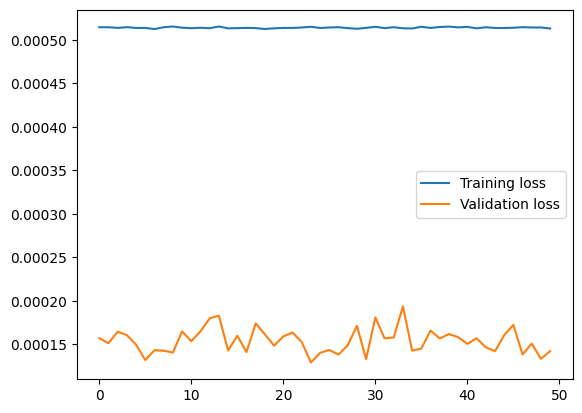

In [19]:
history = model.fit(trainX, trainY, epochs=50, batch_size=16, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [2]:
# Vorhersage = 'Bodentemperatur'
# # Modell speichern
# model.save('Modelle&Scaler/' + Vorhersage+ '_model.h5')

# # Scaler speichern
# joblib.dump(scaler, 'Modelle&Scaler/'+ Vorhersage +'_scaler.save')

In [3]:
Vorhersage = 'Temperatur'
with open('Modelle&Scaler/' + Vorhersage + 'scaler.pkl','wb') as f:
    pickle.dump(scaler, f)
with open('Modelle&Scaler/' + Vorhersage + 'Model.pkl','wb') as f:
    pickle.dump(model, f)

NameError: name 'pickle' is not defined

In [ ]:
n_future = 24
forecast_period_dates = pd.date_range(list(train_dates)[-n_future], periods=n_future, freq='1H').tolist()

forecast = model.predict(trainX[-n_future:])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 824ms/step


In [4]:
# prediction_copies = np.repeat(forecast[1], df_for_training.shape[1], axis=-1)
# prediction_copies = pd.DataFrame(prediction_copies)
# y_pred_future = ssc.unscale(prediction_copies)
# y_pred_future

In [5]:
prediction_copies = np.repeat(forecast, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]

NameError: name 'np' is not defined

In [6]:
forecast_dates = []
for time_i in forecast_period_dates:
    forecast_dates.append(datetime.fromtimestamp(time_i.timestamp()))
    
df_forecast = pd.DataFrame({'createdAt':forecast_dates, Vorhersage:y_pred_future})
df_forecast['createdAt']=pd.to_datetime(df_forecast['createdAt'])
df_forecast

NameError: name 'forecast_period_dates' is not defined

In [7]:
original = df_hourly[['createdAt', Vorhersage]]
original_compare = pd.merge(original, df_forecast,on='createdAt', how='inner', suffixes=('','Pred'))
original_compare

NameError: name 'df_hourly' is not defined

In [8]:
sns.lineplot(data=original_compare, x='createdAt', y=Vorhersage, label='Richitg')
sns.lineplot(data=original_compare, x='createdAt', y=Vorhersage+'Pred', label='Vorhersage')

NameError: name 'sns' is not defined

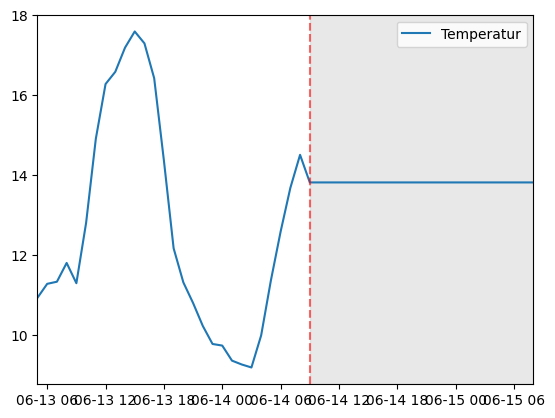

In [ ]:
df_original = df_hourly[['createdAt', Vorhersage]].tail(50)
df_prediction = df_forecast
df_original_cut = df_original[df_original['createdAt'] < df_prediction['createdAt'].min()]

# Combine the dataframes
df_combined = pd.concat([df_original_cut, df_prediction], ignore_index=True)

# Add a column to differentiate between original and predicted values
df_combined['Type'] = ['Original'] * len(df_original_cut) + ['Predicted'] * len(df_prediction)

# Plotting
plt.plot(df_combined['createdAt'], df_combined[Vorhersage], label=Vorhersage)

start_prediction = df_prediction['createdAt'].min()
end_plot = df_combined['createdAt'].max() + timedelta(days=1)
plt.axvspan(start_prediction, end_plot, color='lightgray', alpha=0.5)

# Add vertical dashed red line at the start of predictions
plt.axvline(start_prediction, color='red', linestyle='--', alpha=0.6)


plt.xlim(df_combined['createdAt'].min(), df_combined['createdAt'].max())
plt.legend()
plt.show()